# Example 2 - Pine Island Glacier

This notebook provides an example of a typical ISSM workflow to complete the following:

1. Build and parameterise an ISSM model
2. Conduct a basal friction inversion
3. Run a transient stress balance simulation

In [1]:
import os
import pyissm
import datapool as dp
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

## Setup your modelling environment

Some High-Performance Computing (HPC) infrastructure places limitations on user read/write permissions. To make this notebook flexible for all users, please define some variables used internally in this notebook. The following variables must be defined in the cell below:

- `tutorial_dir = <PATH_TO_NOTEBOOK>` where this notebook is located. By default, this is assumed to be `~/pyISSM/tutorials`
- `tutorial_asset_dir = <PATH_TO_ASSETS>` where all tutorials assets are located. By default, this is assumed to be `~/pyISSM/tutorials/assets`
- `execution_dir = <PATH_TO_DIRECTORY>` where model files will be saved. You must have `rwx` permissions for this directory. By default, this is assumed to be `~/pyISSM/tutorials/models`

NOTE: `execution_dir` must be different from the current working directory of your Python kernel.

In [2]:
tutorial_dir = str(Path.home() / 'pyISSM' / 'tutorials')
asset_dir = tutorial_dir + '/assets'
execution_dir = tutorial_dir + '/models'

# Check that execution directory exists. If not, create it
if not os.path.isdir(execution_dir):
    os.mkdir(execution_dir)

---
## 1. Model mesh

In this example, we first generate a uniform mesh with a resolution of 10 km. We then refine this mesh based on the observed velocity field using anisotropic mesh refinement. At each step, we plot the mesh and velocity field.

In [3]:
# Define mesh parameters
hinit = 10000
hmax = 40000
hmin = 5000
gradation = 1.7
err = 8

# Generate initial uniform mesh
md = pyissm.model.mesh.bamg(pyissm.model.Model(),
                            domain = asset_dir + '/Exp/PIG_DomainOutline.exp',
                            hmax = hinit)

Text(0.5, 1.0, 'Initial uniform model mesh')

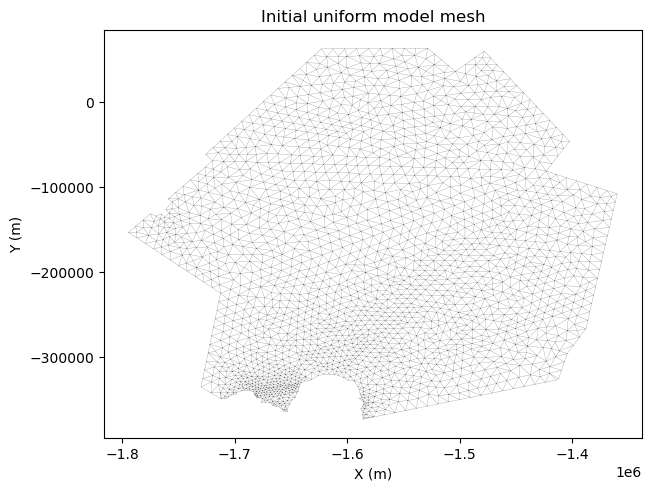

In [4]:
# Plot initial uniform mesh
fig, ax = pyissm.plot.plot_mesh2d(md)
ax.set_title('Initial uniform model mesh')

Here, we load the velocity dataset and interpolate this onto the model mesh. Here we use the ACCESS Cryosphere Data Pool to access the data on NCI Gadi. If running this notebook locally, simply load the dataset using `xarray`.

In [5]:
# Load velocity
catalog = dp.catalog.DataCatalog()
velocity = catalog.load_dataset('measures_insar_based_antarctica_ice_velocity_map', version = 'v2')

# Assign velocity to model
vx_mesh = pyissm.data.interp.xr_to_mesh(velocity, 'VX', md.mesh.x, md.mesh.y, fill_nan = True)
vy_mesh = pyissm.data.interp.xr_to_mesh(velocity, 'VY', md.mesh.x, md.mesh.y, fill_nan = True)
vel_mesh = np.sqrt(vx_mesh**2 + vy_mesh**2)

Construction of a mesh from a given geometry


Text(0.5, 1.0, 'Observed velocity')

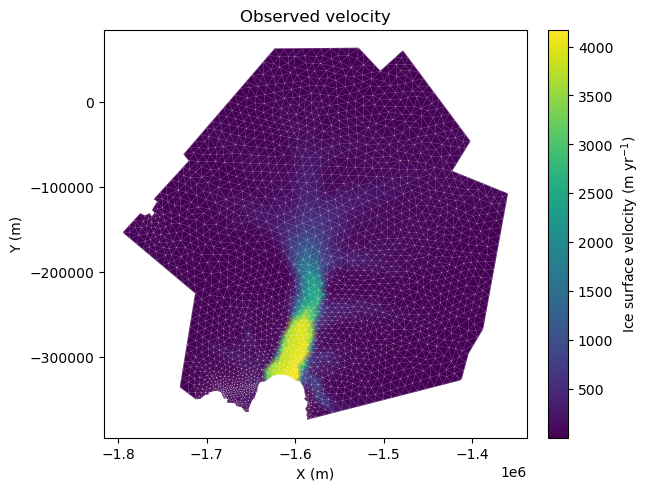

In [6]:
# Visualise velocity
fig, ax = pyissm.plot.plot_model_field(md,
                                       vel_mesh,
                                       show_mesh = True,
                                       mesh_kwargs = {'color': 'white'},
                                       show_cbar = True,
                                       cbar_kwargs = {'label': 'Ice surface velocity (m yr$^{-1}$)'})
ax.set_title('Observed velocity')

In [7]:
## Adapt the mesh based on the velocity
md = pyissm.model.mesh.bamg(md,
                            hmax = hmax,
                            hmin = hmin,
                            gradation = gradation,
                            field = vel_mesh,
                            err = err)

Text(0.5, 1.0, 'Refined model mesh')

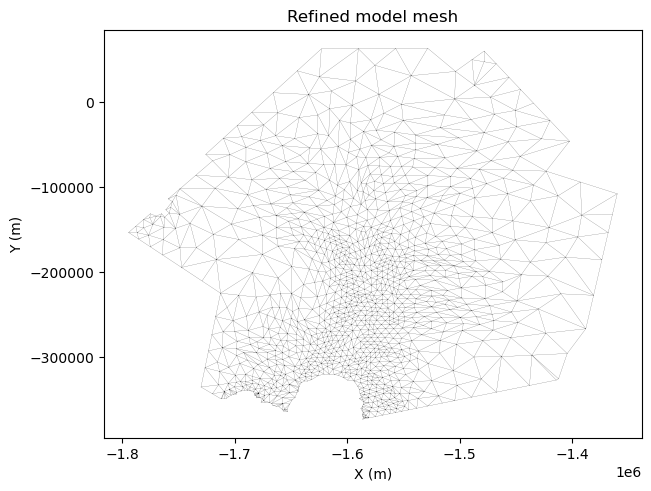

In [8]:
fig, ax = pyissm.plot.plot_mesh2d(md)
ax.set_title('Refined model mesh')

In [9]:
## Save the model
pyissm.model.io.save_model(md, tutorial_dir + '/ex2_PIG_mesh.nc')

# 2. Model Mask

In this example, we use the `mask` variable from BedMachine v3 to define regions of floating and grounded ice. 

In [10]:
## Load the model
md = pyissm.model.io.load_model(tutorial_dir + '/ex2_PIG_mesh.nc')

Text(0.5, 1.0, 'Native BedMachine v3 mask')

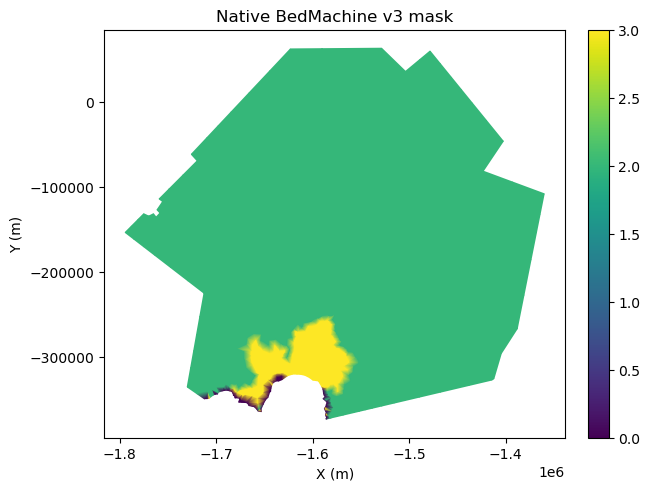

In [11]:
## Load bedmachine v3
bm = catalog.load_dataset('measures_bedmachine_antarctica')

# Interpolate mask to model mesh
## NOTE: Use interpolation_type = 'nearest' to retain unique values for mask
mask = pyissm.data.interp.xr_to_mesh(bm, 'mask', md.mesh.x, md.mesh.y, interpolation_type = 'nearest')
fig, ax = pyissm.plot.plot_model_field(md, mask, show_cbar = True)
ax.set_title('Native BedMachine v3 mask')

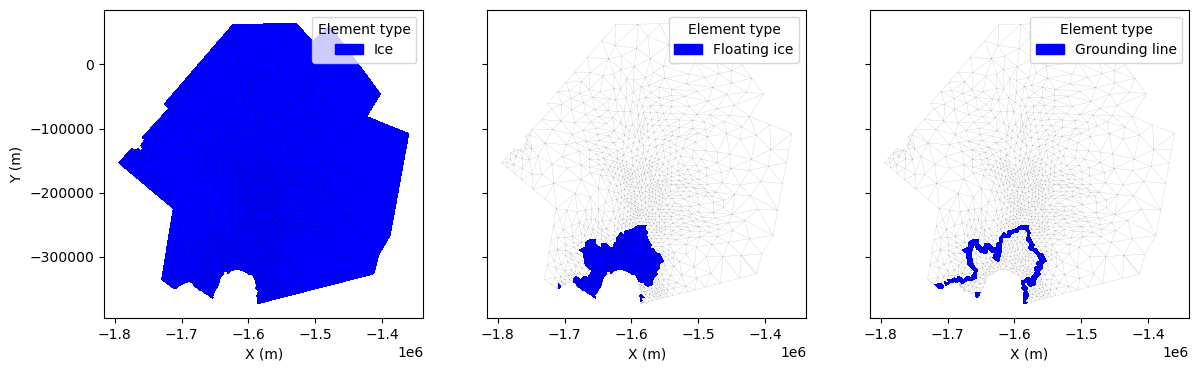

In [12]:
# Assign mask to model levelsets
ice_levelset = np.full(md.mesh.numberofvertices, np.nan)
ocean_levelset = np.full(md.mesh.numberofvertices, np.nan)

## Define ice / no-ice areas
ice_levelset[mask > 0] = -1
ice_levelset[np.isnan(ice_levelset)] = 1

## Define ocean / no-ocean areas
ocean_levelset[mask == 2] = 1
ocean_levelset[mask == 3] = -1
ocean_levelset[mask == 0] = -1

## Assign to model
md.mask.ice_levelset = ice_levelset
md.mask.ocean_levelset = ocean_levelset

# Visualise elements
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (14, 4), sharey = True)
ax1 = pyissm.plot.plot_model_elements(md, md.mask.ice_levelset, md.mask.ocean_levelset, type = 'ice_elements', ax = ax1)
ax2 = pyissm.plot.plot_model_elements(md, md.mask.ice_levelset, md.mask.ocean_levelset, type = 'floating_ice_elements', ax = ax2, ylabel = '')
ax3 = pyissm.plot.plot_model_elements(md, md.mask.ice_levelset, md.mask.ocean_levelset, type = 'grounding_line_elements', ax = ax3, ylabel = '')

In [13]:
## Save the model
pyissm.model.io.save_model(md, tutorial_dir + '/ex2_PIG_mask.nc')

## 3. Parameterize Model

In [14]:
## Load the model
md = pyissm.model.io.load_model(tutorial_dir + '/ex2_PIG_mask.nc')

In [15]:
## Parameterize the model
md = pyissm.model.param.parameterize(md, asset_dir + '/Param/pig_param.py')

 -- LOADING DATASETS -- 


/scratch/tm70/lb9857/access-cryosphere-data-pool/src/datapool/loaders.py:530: UserWarning: WARNING: Timesteps vary between various variables/files. All data files are loaded using
xr.open_mfdataset() and the timestamps are merged. As a result, all-NaN arrays are introduced
for timesteps where a given variable does not have data. Users should use caution when considering
time-varying analysis and might consider 'trimming' data to isolate all non-NaN arrays for a given variable.
  warnings.warn("WARNING: Timesteps vary between various variables/files. All data files are loaded using\n"


 -- ASSIGNING GEOMETRY -- 
 -- ASSIGNING INITIALIZATION FIELDS -- 
ll_to_xy: using south polar stereographic (Std Lat: 71S, Meridian: 0E)
 -- ASSIGNING FORCINGS -- 
ll_to_xy: using south polar stereographic (Std Lat: 71S, Meridian: 0E)
 -- SETTING BOUNDARY CONDITIONS -- 


/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/bc.py:95: UserWarning: pyissm.model.bc._set_sb_dirichlet_bc: Using observed velocities for vx and vy stressbalance model boundary conditions. vz boundary conditions are set to 0.
  warnings.warn('pyissm.model.bc._set_sb_dirichlet_bc: Using observed velocities for vx and vy stressbalance model boundary conditions. vz boundary conditions are set to 0.')
/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/classes/basalforcings.py:116: UserWarning: pyissm.model.classes.basalforcings.default: no groundedice_melting_rate specified -- values set as 0
  warnings.warn('pyissm.model.classes.basalforcings.default: no groundedice_melting_rate specified -- values set as 0')
/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/classes/basalforcings.py:120: UserWarning: pyissm.model.classes.basalforcings.default: no floatingice_melting_rate specified -- values set as 0
  warnings.warn('pyissm.model.classes.basalforcings.default: no floatingice_melting_rate

In [16]:
## Set flow equation (SSA)
md = pyissm.model.param.set_flow_equation(md, SSA = 'all')

Text(0.5, 1.0, 'md.smb.mass_balance')

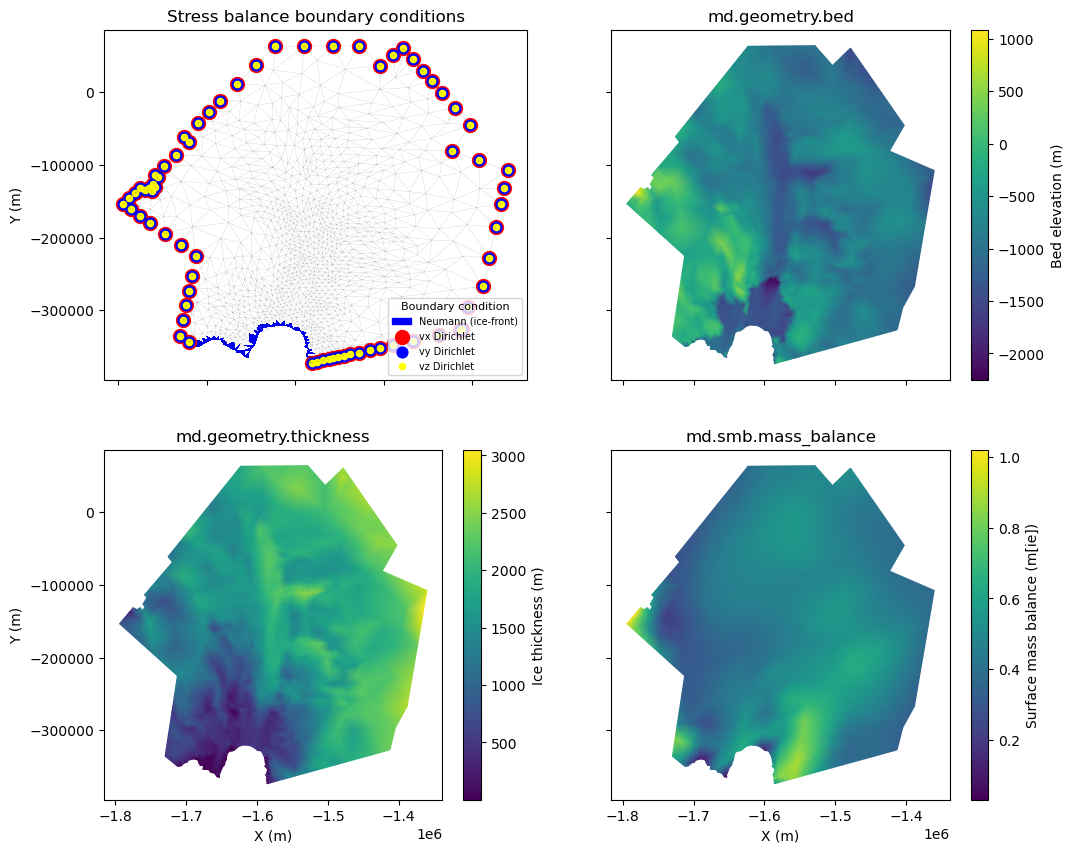

In [17]:
## Visualise various parameterised fields
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12, 10), sharex = True, sharey = True)
ax1 = pyissm.plot.plot_model_bc(md, ax = ax1, xlabel = '', legend_kwargs = {'fontsize': 7, 'title_fontsize': 8, 'loc': 'lower right'})
ax2 = pyissm.plot.plot_model_field(md, md.geometry.bed, ax = ax2, show_cbar = True, xlabel='', ylabel = '', cbar_kwargs = {'label': 'Bed elevation (m)'})
ax3 = pyissm.plot.plot_model_field(md, md.geometry.thickness, ax = ax3, show_cbar = True, cbar_kwargs = {'label': 'Ice thickness (m)'})
ax4 = pyissm.plot.plot_model_field(md, md.smb.mass_balance, ax = ax4, show_cbar = True, ylabel='', cbar_kwargs = {'label': 'Surface mass balance (m[ie])'})

ax1.set_title('Stress balance boundary conditions')
ax2.set_title('md.geometry.bed')
ax3.set_title('md.geometry.thickness')
ax4.set_title('md.smb.mass_balance')

In [18]:
## Save the model
pyissm.model.io.save_model(md, tutorial_dir + '/ex2_PIG_param.nc')

# 4. Perform friction inversion

In [19]:
## Load model
md = pyissm.model.io.load_model(tutorial_dir + '/ex2_PIG_param.nc')

In [20]:
## Define inversion parameters
md.inversion.iscontrol = 1
md.inversion.maxsteps = 20
md.inversion.maxiter = 40
md.inversion.dxmin = 0.1
md.inversion.gttol = 1.0e-4

md.inversion.cost_functions = [101, 103, 501]
md.inversion.cost_functions_coefficients = np.ones((md.mesh.numberofvertices, 3))
md.inversion.cost_functions_coefficients[:,0] = 1
md.inversion.cost_functions_coefficients[:,1] = 1
md.inversion.cost_functions_coefficients[:,2] = 8e-15

md.inversion.control_parameters = ['FrictionCoefficient']
md.inversion.min_parameters = 1 * np.ones(md.mesh.numberofvertices, )
md.inversion.max_parameters = 200 * np.ones(md.mesh.numberofvertices, )

md.stressbalance.restol = 0.01
md.stressbalance.reltol = 0.1
md.stressbalance.abstol = np.nan

md.verbose = md.verbose.deactivate_all()
md.verbose.control = 1

In [21]:
## Solve
md.cluster.np = 2
md.cluster.executionpath = execution_dir
md = pyissm.model.execute.solve(md, 'Stressbalance')

/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/classes/qmu.py:95: UserWarning: pyissm.model.classes.qmu::qmu not yet implemented. Turning off qmu.
  warnings.warn('pyissm.model.classes.qmu::qmu not yet implemented. Turning off qmu.')


Uploading files to cluster...
Transferring PIG-02-19-2026-12-32-17-1337944.tar.gz to cluster gadi-cpu-bdw-0003.gadi.nci.org.au...
Launching job PIG on cluster gadi-cpu-bdw-0003.gadi.nci.org.au...

Ice-sheet and Sea-level System Model (ISSM) version  4.24
(GitHub: https://issmteam.github.io/ISSM-Documentation/ Documentation: https://github.com/ISSMteam/ISSM/)

call computational core:
   preparing initial solution

       x       |  Cost function f(x)  |  List of contributions
====================== step 1/20 ===============================
 x =         0 | f(x) =     11804.48  |       2304.329     9500.155 3.314747e-11
 x =         1 | f(x) =      4145.11  |       131.3317     4013.778 4.442948e-10
====================== step 2/20 ===============================
 x =         0 | f(x) =     4141.722  |       129.7962     4011.926 4.442948e-10
 x =         1 | f(x) =     1829.218  |       41.96253     1787.255 1.371146e-09
====================== step 3/20 ===============================


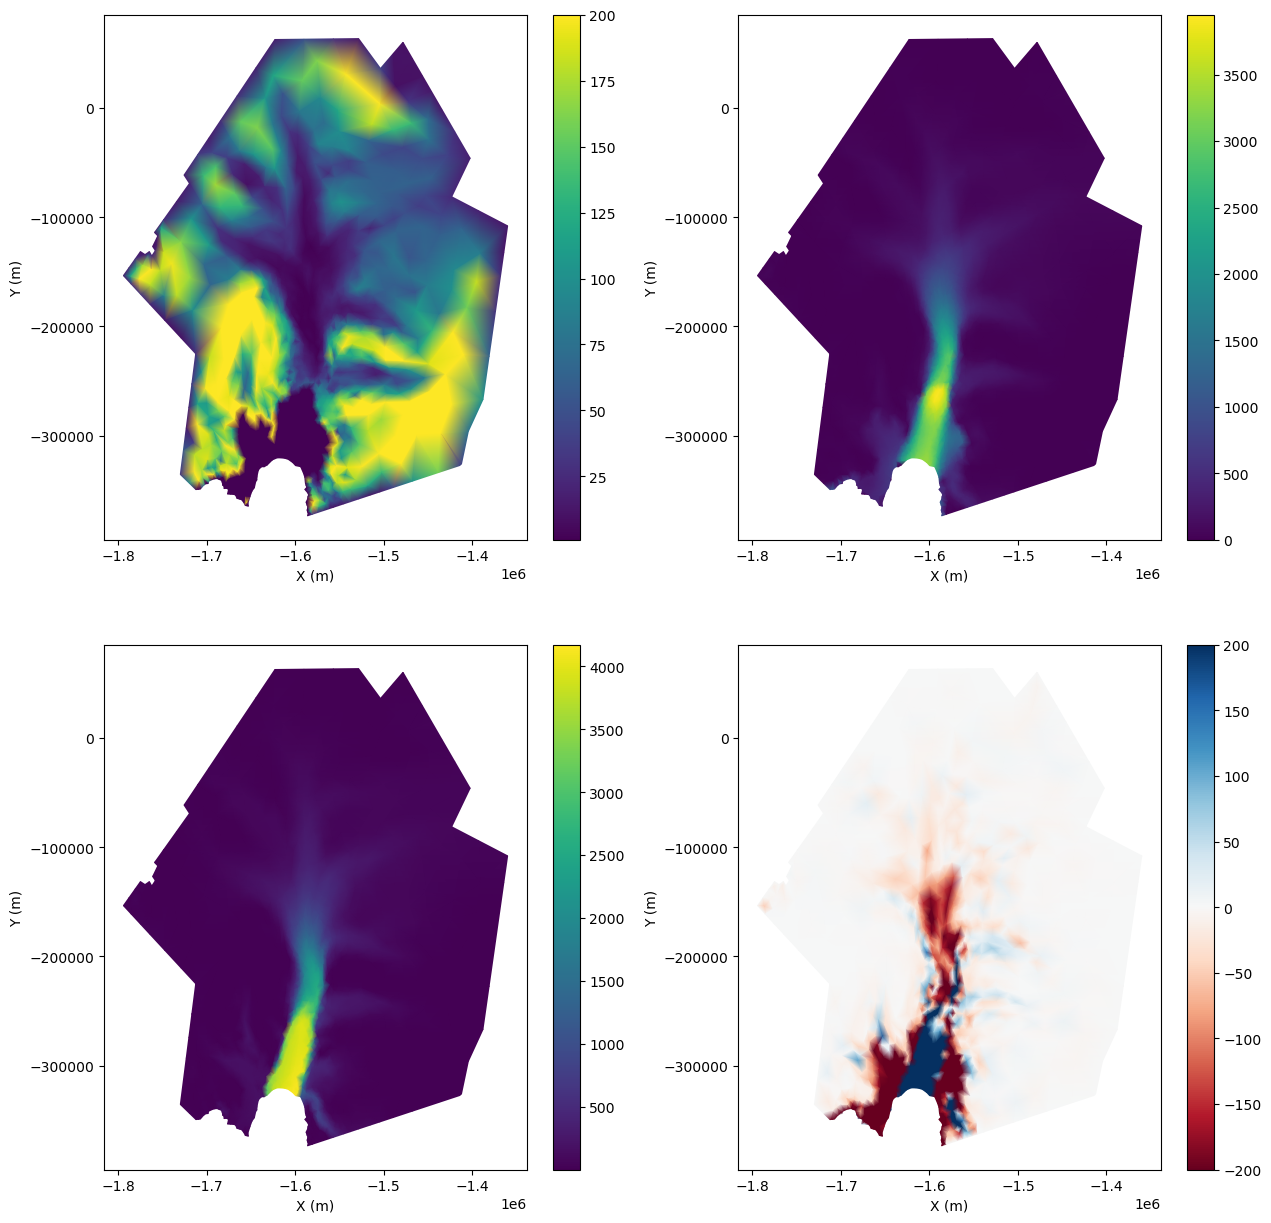

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 15))
ax1 = pyissm.plot.plot_model_field(md, md.results.StressbalanceSolution.FrictionCoefficient, show_cbar = True, ax = ax1)
ax2 = pyissm.plot.plot_model_field(md, md.results.StressbalanceSolution.Vel, show_cbar = True, ax = ax2)
ax3 = pyissm.plot.plot_model_field(md, md.inversion.vel_obs, show_cbar = True, ax = ax3)
ax4 = pyissm.plot.plot_model_field(md, md.inversion.vel_obs - md.results.StressbalanceSolution.Vel, show_cbar = True, cmap = 'RdBu', vmin = -200, vmax = 200, ax = ax4)

In [23]:
## Save the model
pyissm.model.io.save_model(md, tutorial_dir + '/ex2_PIG_control_drag.nc')

## 4. HO Extrusion


In [24]:
## Load model
md = pyissm.model.io.load_model(tutorial_dir + '/ex2_PIG_control_drag.nc')

ℹ️ Processing results group: StressbalanceSolution


In [25]:
## Turn off inversion
md.inversion.iscontrol = 0

## Extrude mesh
md = md.extrude(3, 1)

## Change stressbalance approximation
md = pyissm.model.param.set_flow_equation(md, HO = 'all')

## Solve
md.settings.solver_residue_threshold = 0.1
# md.results = pyissm.model.classes.results.default()
md.verbose.solution = 1
md = pyissm.model.execute.solve(md, 'stressbalance')

Checking model consistency...
Marshalling for PIG.bin


/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/classes/hydrology.py:1433: UserWarning: pyissm.model.classes.hydrology.shreve.extrude: 3D extrusion not implemented for hydrology.shreve. Returning unchanged (2D) hydrology fields.
  warnings.warn('pyissm.model.classes.hydrology.shreve.extrude: 3D extrusion not implemented for hydrology.shreve. Returning unchanged (2D) hydrology fields.')
/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/classes/solidearth.py:127: UserWarning: pyissm.model.classes.solidearth.earth.extrude: 3D extrusion not implemented for solidearth.earth. Returning unchanged (2D) solidearth fields.
  warnings.warn('pyissm.model.classes.solidearth.earth.extrude: 3D extrusion not implemented for solidearth.earth. Returning unchanged (2D) solidearth fields.')
/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/classes/qmu.py:63: UserWarning: pyissm.model.classes.qmu.default.extrude: 3D extrusion not implemented for qmu.default. Returning unchanged (2D) qmu fields.
  warning

Uploading files to cluster...
Transferring PIG-02-19-2026-12-32-42-1337944.tar.gz to cluster gadi-cpu-bdw-0003.gadi.nci.org.au...
Launching job PIG on cluster gadi-cpu-bdw-0003.gadi.nci.org.au...

Ice-sheet and Sea-level System Model (ISSM) version  4.24
(GitHub: https://issmteam.github.io/ISSM-Documentation/ Documentation: https://github.com/ISSMteam/ISSM/)

call computational core:
   computing new velocity
   computing basal mass balance
   computing vertical velocities
write lock file:

   FemModel initialization elapsed time:   0.202881
   Total Core solution elapsed time:       2.87116
   Linear solver elapsed time:             0.795482 (28%)

   Total elapsed time: 0 hrs 0 min 3 sec
Waiting for job to complete...
wait_on_lock not implemented yet
Job completed -- loading results from cluster...
Retrieving results from cluster gadi-cpu-bdw-0003.gadi.nci.org.au...


/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/mesh.py:108: UserWarning: process_mesh: 3D model found. Processing as 2D mesh.
  warnings.warn('process_mesh: 3D model found. Processing as 2D mesh.')


(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='X (m)', ylabel='Y (m)'>)

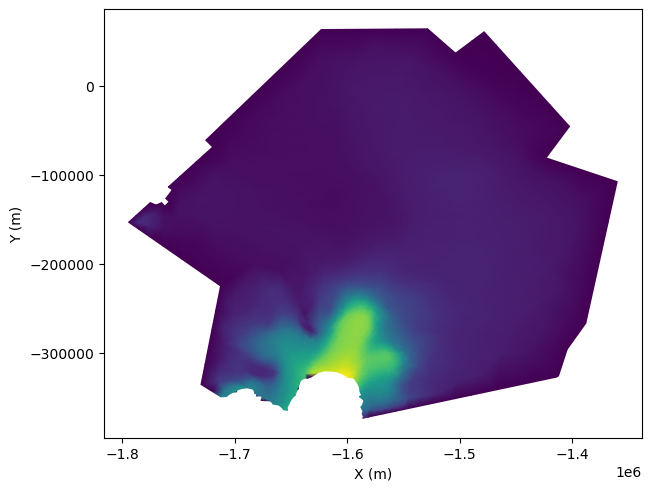

In [26]:
## Plot depth-averaged velocity field
pyissm.plot.plot_model_field(md, md.results.StressbalanceSolution.Vel, depth_average=True)

In [27]:
## Save the model
pyissm.model.io.save_model(md, tutorial_dir + '/ex2_PIG_HO.nc')